In [1]:
using Plots
using PlotlyJS
using Statistics
using QuadGK
using MAT

## constants

In [2]:
# physical constants
g = 9.81 # gravitational acceleration [m/s^2]

# fluid properties 
rho_a    = 1.225;     # Density of air [kg/m^3]
c_a      = 1005;      # Specific heat of air [J/KgK]

# building model properties
v_a      = 2880;     # Volume of air inside the building [m^3]
A_f     = 2*90;       # Area of the 3 floors [m^2]
th      = 0.1;       # Thickness of thermal mass floors[m]
E_int    = 250;      # Internal loads due to occupancy, lighting and equipment [W]

# material properties
rho_f   = 2300;     # Density of Thermal Mass concrete [kg/m^3]
k_f     = 0.8;         # Conductivity of Thermal Mass concrete [W/mK]
c_f     = 750;        # Specific heat of Thermal Mass concrete [J/KgK]
h  = 4;           # Convective heat coefficient [W/m2.K]

## functions

In [3]:

function conductionMatrix(lambda, dt, dx, Nx)
    """calculate temperature evolution within a fabric """
    A = zeros(Nx, Nx)

    A[1,1] = 1-lambda;  
    A[1,2] = lambda;
    A[Nx,Nx-1] = lambda;
    A[Nx,Nx] = 1-lambda;  
    
    # all other rows 
    for i = 2:Nx-1
        A[i, i-1] = lambda;
        A[i, i] = 1-2*lambda;
        A[i, i+1] = lambda;
    end

    return A

end

function cd_pivot(alpha)
    "calculate discharge coefficient based on window opening angle"
    W=1;
    H=1;
    W_pivot = z -> (1/W^2 + 1/(2*(H-z)*tand(alpha)+sind(alpha)*W).^2) .^(-1/2)
    h = H * (1- cosd(alpha));
    integral, est = quadgk(W_pivot,h,H) #rtol=1e-8 -> error when go to last element of angle array
    A_eff = W*h + integral ;
    Cd0 = 0.611;
    Cd = A_eff / (H*W) * Cd0;   
    
end

cd_pivot (generic function with 1 method)

## initialize variables for convective heat transfer calculation 

In [4]:
# Discrete variables for 1D conduction calculation over time_val => T(t+1,x) = A*T(t,x) + b
dt = 15;
dx = th/10;
x = range(0, th, step = dx)  |> collect 
Nx = length(x)

11

In [5]:
# initialize A matrix 
alpha = k_f/(rho_f*c_f) # thermal conductivity / (density * specific heat )
lambda = alpha * dt / dx^2 # this could all go into the matrix 
A = conductionMatrix(lambda, dt, dx, Nx)

## initialize variables for natural ventilation calculation

In [8]:
# window properties 
w1 = Dict("alpha" => 42, "area" => 1.61, "l" => 11.34)
w1["cd"] = cd_pivot(w1["alpha"])

w2 = Dict("alpha" => 42, "area" => 1.755, "l" => 6.62)
w2["cd"] = cd_pivot(w2["alpha"])

w3 = Dict("alpha" => 42, "area" => 1.755, "l" => 2.07)
w3["cd"] = cd_pivot(w3["alpha"]);

## initialize other variables

In [77]:
time_val = range(0, dt*20, step = dt)
to_Kelvin = 273.5
T_in_meas = sind.(time_val) .+ to_Kelvin
T_out_meas = T_in_meas .- (sind.(time_val.* 0.1)) .- 0.1 

# values to calculate 
T_in = zeros(length(time_val))
T_f = zeros(length(x),length(time_val));

# values to
T_in[1] = T_in_meas[1];  # interior starts at the fabric?
T_f[:,1] .= T_in_meas[1]- 1e-5;
# TODO -> issue: fabric and calculated interior air temperature cant be initialized to equal each other if they are being subtracted to determine the convective heat flux??

# empty vectors 
Q1 = zeros(length(time_val));
Q2 = zeros(length(time_val));
Q3 = zeros(length(time_val));
Q_tot = zeros(length(time_val));
E_nv = zeros(length(time_val));
E_conv_out_time = zeros(length(time_val)); # save value of E_conv over time
E_conv_in_time = zeros(length(time_val));
b = zeros(1,Nx)
Eist = zeros(length(time_val));

## dynamic thermal model

In [97]:
for t=1:length(time_val)-1

    # calculate E_nv at each time_val step 
    # TODO make function that calculates E_nv, how was this done before we knew outside vs inside?
    for (w, Q) in zip([w1, w2, w3], [Q1, Q2, Q3]) 
        
        # TODO adjust this to consider wind ventilation, in addition to buoyancy 
        Q[t] = w["cd"] * w["area"] * sqrt(2*g*w["l"] * (T_in_meas[t]-T_out_meas[t]) /(T_out_meas[t]))
    end
    Q_tot[t] = Q1[t] + Q2[t] + Q3[t]
    E_nv[t] = rho_a * c_a * Q_tot[t] * (T_out_meas[t] - T_in[t])


    # # wall boundary conditions 
    # -> outside to wall 
    E_conv_out = h * A_f * (T_out_meas[t]- T_f[1,t] )
    E_conv_out_time[t] =  E_conv_out # save value of E_conv over time
    b[1] = - lambda * dx / (k_f * E_conv_out)

    # -> wall to inside 
    E_conv_in = h * A_f * (T_f[Nx,t] - T_in[t])
    E_conv_in_time[t] =  E_conv_in # save value of E_conv over time
    b[Nx] = - lambda * dx / (k_f * E_conv_in)
    print("b $(unique(b)), time_val $t \n")

    # calculate surface temperature at each time_val step
    T_f[:, t+1] = A*T_f[:,t] + b'

    # calculate interior average air temperaure at each time_val step 
    T_in[t + 1] = T_in[t] + (E_conv_in *  A_f + E_int + E_nv[t]) * dt/(v_a * rho_a * c_a)
 end

b [1.2078502536238167e-5, 0.0, 0.12077294716482577], time_val 1 
b [-9.10531741589148e-6, 0.0, -1.0065166573959873e-5], time_val 2 
b [-3.473761989474388e-6, 0.0, -2.725128370600828e-5], time_val 3 
b [-2.284514598493157e-6, 0.0, -0.00011249026225994173], time_val 4 
b [-1.8257147492280314e-6, 0.0, 0.00028696019068425116], time_val 5 
b [-1.6422427134911385e-6, 0.0, 0.00011655028004328808], time_val 6 
b [-1.624205063436837e-6, 0.0, 9.211265355939907e-5], time_val 7 
b [-1.766440862339302e-6, 0.0, 8.617981169829438e-5], time_val 8 
b [-2.163875791892194e-6, 0.0, 8.731065415871127e-5], time_val 9 
b [-3.23197252159767e-6, 0.0, 9.380265057869483e-5], time_val 10 
b [-8.553083068718226e-6, 0.0, 0.00010718630039853093], time_val 11 
b [9.649061805240534e-6, 0.0, 0.00013298466893454762], time_val 12 
b [2.9529047685097204e-6, 0.0, 0.00018894273710762935], time_val 13 
b [1.743738228542679e-6, 0.0, 0.0003672798428646879], time_val 14 
b [1.260213109862037e-6, 0.0, -0.006500505160685708], tim

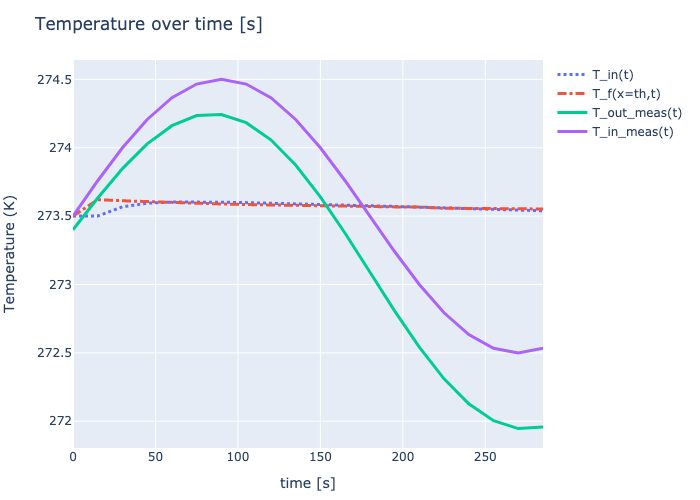

In [99]:
labels = ["T_in(t)","T_f(x=th,t)","T_out_meas(t)","T_in_meas(t)"];
vals = [T_in[1:end-1], T_f[end, 1:end-1], T_out_meas[1:end-1], T_in_meas[1:end-1]]
linewidths = [3,3,3,3]
dashtypes = ["dot", "dashdot", "none", "none"]


traces = [PlotlyJS.scatter(x=vec(time_val),  y=val, mode="lines", name=label, line=attr(width=lw, dash=dt)) for (val,label, lw, dt) in zip(vals, labels, linewidths, dashtypes)];


p3 = PlotlyJS.plot(traces, Layout(;title="Temperature over time [s]", showlegend=true, xaxis_title=" time [s]", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=false));
p3

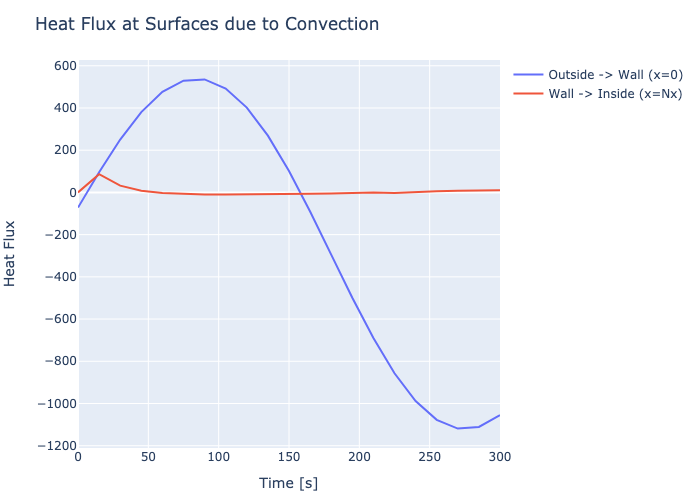

In [100]:
time_val_arr = time_val |> collect;
trace1 = PlotlyJS.scatter(x=time_val_arr, y=E_conv_in_time, mode="lines", name="Wall -> Inside (x=Nx)")

trace2 = PlotlyJS.scatter(x=time_val_arr, y=E_conv_out_time,mode="lines", name="Outside -> Wall (x=0)")

# .plot(t/3600, T_int, mode="lines", name="T_int", )
PlotlyJS.plot([trace2, trace1], Layout(;title="Heat Flux at Surfaces due to Convection", showlegend=true, xaxis_title="Time [s]", yaxis_title="Heat Flux" ),  config=PlotConfig(scrollZoom=false))

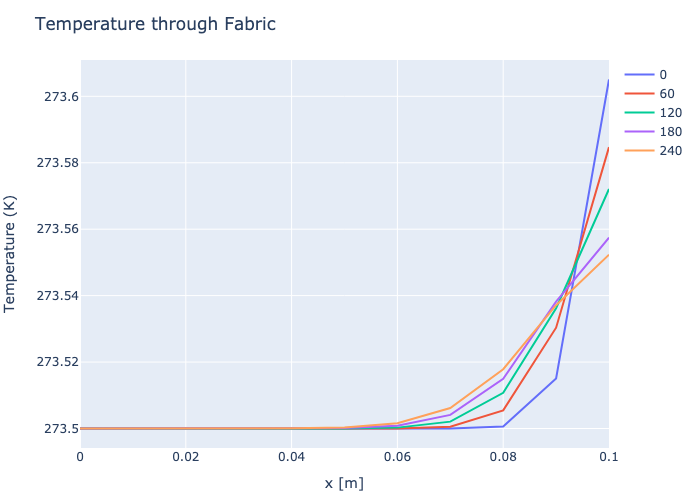

In [98]:
traces = [PlotlyJS.scatter(x=x,  y=T_f[:, 4*i], mode="lines", name=time_val_arr[4*(i-1)+1]) for i in 1:5];
p3 = PlotlyJS.plot(traces, Layout(;title="Temperature through Fabric", showlegend=true, xaxis_title="x [m]", yaxis_title="Temperature (K)" ),  config=PlotConfig(scrollZoom=false));
p3

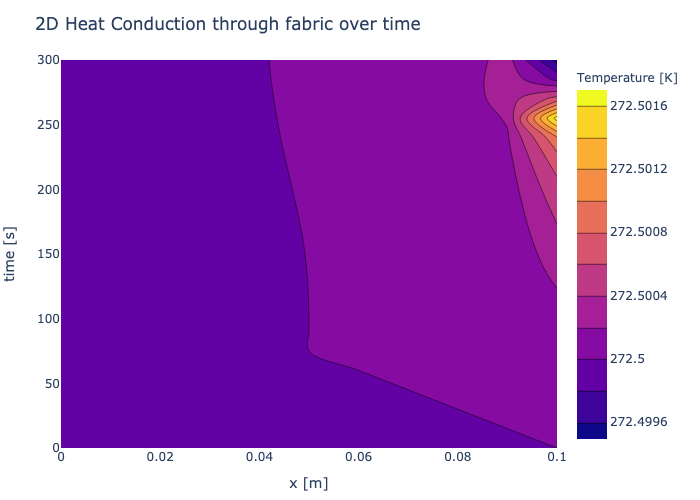

In [68]:

PlotlyJS.plot(PlotlyJS.contour(x=x, y=time_val_arr, z=T_f',     colorbar=attr(
    title="Temperature [K]", # title here
)), 
Layout(;title="2D Heat Conduction through fabric over time", xaxis_title="x [m]", yaxis_title="time [s]"),
config=PlotConfig(scrollZoom=false))